In [2]:
import util
%load_ext autoreload  
%autoreload 2  
!hostname  
!pwd  
import os
import sys

print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
oliva-titanrtx-1.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [3]:
import os, sys, glob, pickle
from functools import partial  

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange, reduce, repeat

In [ ]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState


import optax

In [ ]:
def smooth_curve(x, window, kernel='uniform'):
    assert len(x) > window and window % 2 == 1
    before, after = x[:window//2].mean(), x[-window//2:].mean()
    x = np.pad(x, (window//2, window//2), mode='constant', constant_values=(before, after))
    if kernel == 'uniform':
        kernel = np.ones(window)/window
    else:
        raise NotImplementedError
    return np.convolve(x, kernel, mode='valid')

In [ ]:
class Agent(nn.Module):
    d_obs: int
    d_act: int

    @nn.compact
    def __call__(self, x):
        act = nn.Sequential([
            nn.Dense(64),
            nn.tanh,
            nn.Dense(64),
            nn.tanh,
            nn.Dense(self.d_act, kernel_init=nn.initializers.normal(stddev=0.01)),
        ])(x)
        return act


In [149]:
with open("/data/vision/phillipi/akumar01/synthetic-mdps-data/datasets/mujoco/InvertedPendulum/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
d_obs, d_act = dataset['obs'].shape[-1], dataset['act_mean'].shape[-1]

In [150]:
def sample_batch(rng, dataset, batch_size):
    rng, _rng1, _rng2 = split(rng, 3)
    i_b = jax.random.randint(_rng1, (batch_size,), 0, dataset['obs'].shape[0])
    i_t = jax.random.randint(_rng2, (batch_size,), 0, dataset['obs'].shape[1])
    return jax.tree_map(lambda x: x[i_b, i_t], dataset)

In [151]:
import gymnasium as gym

def make_env(env_id, idx, capture_video, vid_name, gamma=0.99):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"/data/vision/phillipi/akumar01/synthetic-mdps-data/videos/{vid_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.FlattenObservation(env)  # deal with dm_control's Dict observation space
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        return env
    return thunk


In [47]:
rng = jax.random.PRNGKey(0)
agent = Agent(d_obs, d_act)
batch = sample_batch(rng, dataset, 1)

rng, _rng = split(rng)
agent_params = agent.init(_rng, jax.tree_map(lambda x: x[0], batch['obs']))

agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0)))

def iter_step(state, batch):
    def loss_fn(params):
        act_pred = agent_forward(params, batch['obs'])
        return jnp.mean(jnp.square(act_pred - batch['act_mean']))
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    return state.apply_gradients(grads=grad), loss
iter_step = jax.jit(iter_step)

tx = optax.chain(#optax.clip_by_global_norm(1.),
                 optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

pbar = tqdm(range(15000))
for i in pbar:
    rng, _rng = split(rng)
    batch = sample_batch(_rng, dataset, 32)
    train_state, loss = iter_step(train_state, batch)
    pbar.set_postfix({'loss': loss})

  0%|          | 0/15000 [00:00<?, ?it/s]

In [33]:
envs = gym.vector.SyncVectorEnv( [make_env("InvertedPendulum-v4") for i in range(64)] )

In [50]:
stats = []
obs, info = envs.reset()
for i in tqdm(range(1005)):
    act = agent_forward(train_state.params, obs)
    obs, rew, term, trunc, infos = envs.step(act)
    if "final_info" in infos:
        for info in infos["final_info"]:
            if info and "episode" in info:
                stats.append((info["episode"]["r"], info["episode"]["l"]))

  0%|          | 0/1005 [00:00<?, ?it/s]

In [51]:
np.array(stats)[:, 0].mean()

4542.3582191467285

In [152]:
def rollout_fn(train_state, vid_name):
    capture_video = vid_name is not None
    envs = gym.vector.SyncVectorEnv( [make_env("InvertedPendulum-v4", i, capture_video=capture_video, vid_name=vid_name) for i in range(64)] )
    stats = []
    obs, info = envs.reset()
    for i in tqdm(range(1005)):
        act = agent_forward(train_state.params, obs)
        obs, rew, term, trunc, infos = envs.step(act)
        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    stats.append((info["episode"]["r"], info["episode"]["l"]))
    return np.array(stats)[:, 0].mean()


In [154]:
rng = jax.random.PRNGKey(0)
agent = Agent(d_obs, d_act)
batch = sample_batch(rng, dataset, 1)

rng, _rng = split(rng)
agent_params = agent.init(_rng, jax.tree_map(lambda x: x[0], batch['obs']))

agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0)))

def iter_step(state, batch):
    def loss_fn(params):
        act_pred = agent_forward(params, batch['obs'])
        return jnp.mean(jnp.square(act_pred - batch['act_mean']))
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    return state.apply_gradients(grads=grad), loss
iter_step = jax.jit(iter_step)

tx = optax.chain(#optax.clip_by_global_norm(1.),
                 optax.adamw(3e-4, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=agent.apply, params=agent_params, tx=tx)

pbar = tqdm(range(10000+1))
losses, rets, iters = [], [], []
for i in pbar:
    if i%1000==0:
        # ret = rollout_fn(train_state, vid_name=f"halfcheetah_{i}")
        ret = rollout_fn(train_state, vid_name=None)
        rets.append(ret)
        iters.append(i)
        
    rng, _rng = split(rng)
    batch = sample_batch(_rng, dataset, 32)
    train_state, loss = iter_step(train_state, batch)
    pbar.set_postfix({'loss': loss})
    losses.append(loss)


  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

  0%|          | 0/1005 [00:00<?, ?it/s]

In [155]:
losses, rets, iters = np.array(losses), np.array(rets), np.array(iters)

ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

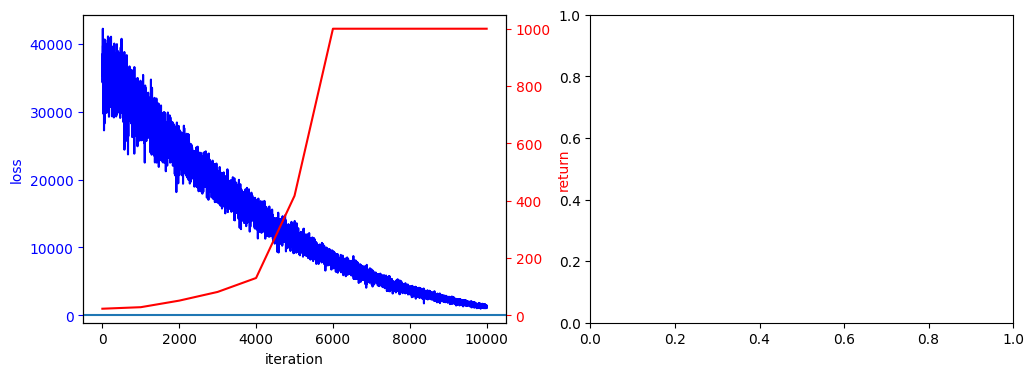

In [156]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# plot losses on one y axis and returns on another
ax1 = plt.gca()
ax1.plot(losses, 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(iters, rets, 'r-')
ax2.set_ylabel('return', color='r')
ax2.tick_params('y', colors='r')
plt.axhline(0)

# plt.xlim(0, 15000)

plt.subplot(1, 2, 2)
plt.plot(losses[:-1].reshape(-1, 1000).mean(axis=-1), rets)
plt.scatter(losses[:-1].reshape(-1, 1000).mean(axis=-1), rets)
plt.axvline(.2)
plt.xscale('log')
plt.ylabel('return')
plt.xlabel('loss')

plt.suptitle("InvertedPendulum-v4")
plt.tight_layout()
plt.show()



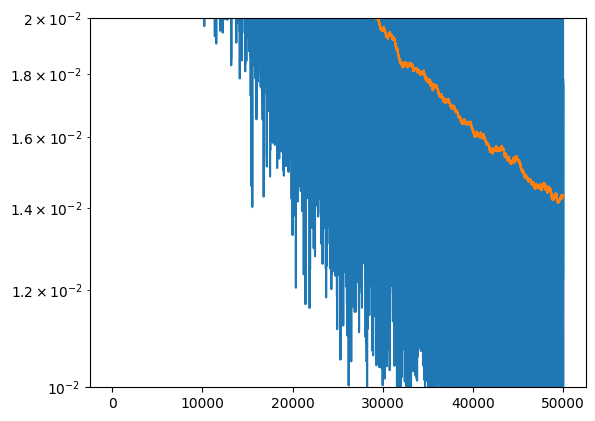

In [108]:
plt.plot(losses)
plt.plot(smooth_curve(losses, 1001))
plt.ylim(1e-2, 2e-2)
plt.yscale('log')

In [85]:
from icl_bc_ed import BCTransformer, construct_dataset, sample_batch_from_dataset
from util import load_pkl, tree_cat, tree_stack

In [42]:
dataset, _, _ = construct_dataset(["/data/vision/phillipi/akumar01/synthetic-mdps-data/datasets/mujoco/HalfCheetah/dataset.pkl"], [], 128, 21, (1., 1.))

Found 1 datasets
Loading dataset from /data/vision/phillipi/akumar01/synthetic-mdps-data/datasets/mujoco/HalfCheetah/dataset.pkl
Dataset shape: {'act': ((64, 131072, 6), dtype('float32')), 'done': ((64, 131072), dtype('float32')), 'obs': ((64, 131072, 17), dtype('float32')), 'rew': ((64, 131072), dtype('float32')), 'time': ((64, 131072), dtype('int32'))}


In [47]:
agent = BCTransformer(d_obs=128, d_act=21, n_layers=4, n_heads=8, d_embd=256, ctx_len=512)
agent_params = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/train_bc_aug/mujoco/all-HalfCheetah/", "ckpt_0050000")['params']
agent_forward = jax.jit(jax.vmap(agent.apply, in_axes=(None, 0, 0, 0)))

In [104]:
rng = jax.random.PRNGKey(0)
mse_act = []
for i in tqdm(range(100)):
    rng, _rng = split(rng)
    batch1 = sample_batch_from_dataset(_rng, dataset, 64, 512, 512)
    rng, _rng = split(rng)
    batch2 = sample_batch_from_dataset(_rng, dataset, 64, 512, 512)
    
    batch = batch1
    batch['obs'] = jnp.concatenate([batch1['obs'][:, :500], batch2['obs'][:, -12:]], axis=1)
    batch['act'] = jnp.concatenate([batch1['act'][:, :500], batch2['act'][:, -12:]], axis=1)
    
    outi = agent_forward(agent_params, batch['obs'], batch['act'], batch['time'])
    mse_acti = ((outi['act_now'] - outi['act_now_pred'])**2).mean(axis=-1).mean(axis=0)
    mse_act.append(mse_acti)
mse_act = tree_stack(mse_act)

  0%|          | 0/100 [00:00<?, ?it/s]

In [105]:
mse_act = mse_act.mean(axis=0)

(0.0, 1.0)

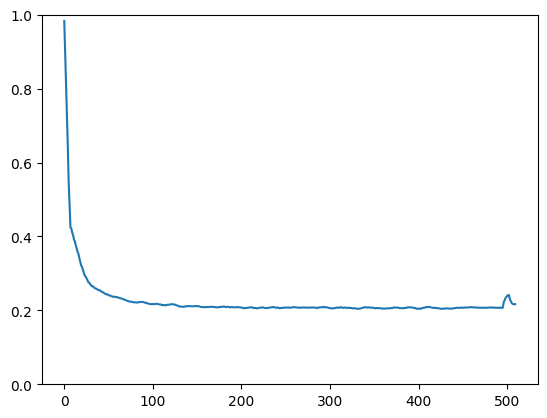

In [110]:
plt.plot(smooth_curve(np.array(mse_act), 7))
plt.ylim(0, 1)
# plt.yscale('log')

In [96]:
batch['obs'].shape

(64, 512, 128)

In [111]:
metrics = load_pkl("/data/vision/phillipi/akumar01/synthetic-mdps-data/train_bc_aug/mujoco/all-HalfCheetah/", "metrics_train")

In [118]:
a = metrics['mse_act'][:, 256:].mean(axis=-1)

(0.2, 0.3)

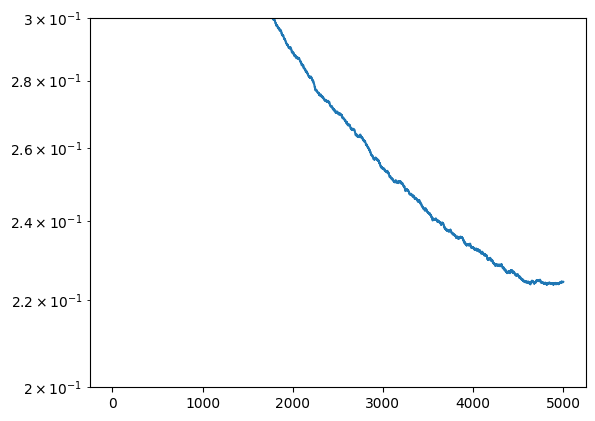

In [124]:
plt.plot(smooth_curve(a, 501))
plt.yscale('log')
plt.ylim(2e-1, 3e-1)